<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# MORE group project
*WIM-data analysis*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
import matplotlib.gridspec as gridspec
from scipy import stats
import pyvinecopulib as pv
from scipy.stats import rankdata
from py_banshee.copula_test import cvm_statistic

In [3]:
# List of axle load columns
axle_load_columns = [
    'axle 1 [kg]', 'axle 2 [kg]', 'axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]', 
    'axle 6 [kg]', 'axle 7 [kg]', 'axle 8 [kg]', 'axle 9 [kg]', 'axle 10 [kg]', 
    'axle 11 [kg]', 'axle 12 [kg]', 'axle 13 [kg]', 'axle 14 [kg]'
]

# List of spacing columns
spacing_columns = [
    'ax1 - ax2 [cm]', 'ax2 - ax3 [cm]', 'ax3 - ax4 [cm]', 'ax4 - ax5 [cm]', 
    'ax6 - ax7 [cm]', 'ax7 - ax8 [cm]', 'ax8 - ax9 [cm]', 'ax10 - ax11 [cm]', 
    'ax11 - ax12 [cm]', 'ax12 - ax13 [cm]', 'ax13 - ax14 [cm]'
]

## Importing data

In [5]:
%%capture
# Importing data and combining in 1 large dataframe
data_left = pd.read_csv('DATA_RW_12L_April2013.csv', delimiter=';', skipinitialspace=True, index_col=False);
data_right = pd.read_csv('DATA_RW_12R_April2013.csv', delimiter=';', skipinitialspace=True, index_col=False);
combined_data = pd.concat([data_left, data_right], ignore_index=True)

# Some renaming of columns and adding of new columns to make things easier
combined_data.rename(columns={'ax3- ax4 [cm]': 'ax3 - ax4 [cm]'}, inplace=True)
combined_data['wheelbase [cm]'] = combined_data[spacing_columns].sum(axis=1)
combined_data['number_of_axles'] = combined_data[axle_load_columns].count(axis=1)

In [6]:
combined_data.head()

,date,time,ID,lane,subcat,velocity [km/h],length [cm],mass [kg],axle 1 [kg],axle 2 [kg],...,ax4 - ax5 [cm],ax6 - ax7 [cm],ax7 - ax8 [cm],ax8 - ax9 [cm],ax10 - ax11 [cm],ax11 - ax12 [cm],ax12 - ax13 [cm],ax13 - ax14 [cm],wheelbase [cm],number_of_axles
0,01-Apr-2013,06:29:29,24516576,RW-12-L-2,T11O3,87,1716,15694,5392,4506,...,132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1226.0,5
1,01-Apr-2013,06:45:35,24516659,RW-12-L-2,T11O3,84,1565,15024,5310,4242,...,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1261.0,5
2,01-Apr-2013,07:08:57,24516768,RW-12-L-2,V112,105,1158,8750,1428,2270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,855.0,4
3,01-Apr-2013,07:34:19,24516902,RW-12-L-2,T11O3,88,1693,18391,6216,4764,...,133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208.0,5
4,01-Apr-2013,07:49:12,24516995,RW-12-L-2,B12,101,1318,19375,7209,8221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,813.0,3


## Cleaning data with filters

In [8]:
# Condition 1: Wheelbase < 1 meter
condition_1 = combined_data['wheelbase [cm]'] < 100  

# Condition 2: Wheelbase < 30m and spacing > 10m
condition_2 = (combined_data['wheelbase [cm]'] < 3000) & ((combined_data['ax1 - ax2 [cm]'] > 1000) | (combined_data['ax13 - ax14 [cm]'] > 1000))

# Condition 3: Wheelbase > 40 meters
condition_3 = combined_data['wheelbase [cm]'] > 4000  

# Condition 4: Axle load <= 0 tons
condition_4 = (combined_data[axle_load_columns].le(0)).any(axis=1)

# Condition 5: Axle load > 40 tons
condition_5 = (combined_data[axle_load_columns].gt(40000)).any(axis=1)

# Condition 6: Axle weight > 15 tons and > 85% of gross vehicle weight
condition_6 = (combined_data[axle_load_columns].max(axis=1) > 15000) & (combined_data[axle_load_columns].max(axis=1) / combined_data['mass [kg]'] > 0.85)

# Condition 7: Gross vehicle weight <= 0 tons
condition_7 = combined_data['mass [kg]'] <= 0  

# Condition 8: Sum of axle loads not within 50kg of gross vehicle weight
sum_axle_loads = combined_data[axle_load_columns].sum(axis=1)
condition_8 = (abs(sum_axle_loads - combined_data['mass [kg]']) > 50)

# Condition 9: less or equal to 2 m first two axles, one of which is larger than 10 tons and over 2.5 times heavier than other axle.
closely_spaced = combined_data['ax1 - ax2 [cm]'] <= 200
axle1_load = combined_data['axle 1 [kg]']
axle2_load = combined_data['axle 2 [kg]']
one_axle_heavy = (axle1_load > 10000) | (axle2_load > 10000)
axle_weight_ratio = (axle1_load / axle2_load > 2.5) | (axle2_load / axle1_load > 2.5)
condition_9 = closely_spaced & one_axle_heavy & axle_weight_ratio

# Condition 10: First spacing between the first two axles larger than 15m
condition_10 = combined_data['ax1 - ax2 [cm]'] > 1500  

# Condition 11: Any spacing less than 0.4 meters
condition_11 = combined_data[spacing_columns].min(axis=1) < 40  # Less than 0.4 meters

# Condition 12: Mismatch between number of axle spacings and number of axle loads
condition_12 = combined_data[axle_load_columns].count(axis=1) != (combined_data[spacing_columns].count(axis=1) + 1)

## Condition 13: Sum of axle spacings not within 50 mm of wheelbase.
## Unfortunately, we didn't have a seperate column for wheelbase in our csv file, so we cant do this calculation. We just added one ourselfs by summing the axle spacing, so comparing them would result in zero difference for all vehicles.

#Condition 14: Number of axles below or equal to 1.
condition_14 = combined_data[axle_load_columns].count(axis=1) <= 1

#Condition 15: First axle spacing in the interval of 10 m–15 m.
condition_15 = (combined_data['ax1 - ax2 [cm]'] >= 1000) & (combined_data['ax1 - ax2 [cm]'] <= 1500)

#Condition 16: 16.	Each spacing in range of 0,4 m–0,7 m.
condition_16 = combined_data[spacing_columns].ge(40).all(axis=1) & combined_data[spacing_columns].lt(70).all(axis=1)

#Condition 17: Each spacing in range of 0,7 m–1,0 m.
condition_17 = combined_data[spacing_columns].ge(70).all(axis=1) & combined_data[spacing_columns].lt(100).all(axis=1)

#Condition 18: Each axle load in the interval of 25 tons–40 tons.
condition_18 = combined_data[axle_load_columns].ge(25000).all(axis=1) & combined_data[axle_load_columns].lt(40000).all(axis=1)

#Condition 19: Each axle load below 0,5 tons.
condition_19 = combined_data[axle_load_columns].lt(500).all(axis=1)

#Condition 20: Vehicles with same WIM identification number (ID).
condition_20 = combined_data.duplicated(subset='ID', keep=False)

#Condition 21: Vehicles with a gross vehicle weight below 3,56 tons.
condition_21 = combined_data['mass [kg]'] < 3560

#Condition 22: Vehicles with a gross vehicle weight above 112 tons.
condition_22 = combined_data['mass [kg]'] > 112000

#Condition 23: Vehicles with a speed greater than 120 km/h.
condition_23 = (combined_data['velocity [km/h]'] > 120) | (combined_data['velocity [km/h]'] < 60)

#Condition 24: The vehicles with gross vehicle weight larger than 71.3 tons and or length bumper-to-bumper above than 25,5 m and axle spacing above 12,5 m (data related to a combination of two vehicles).
condition_24 = (
    (combined_data['mass [kg]'] > 71300) |
    (
        (combined_data['length [cm]'] > 2550) &
        (combined_data[spacing_columns].max(axis=1) > 1250)
    )
)

#Condition 25: Vehicles with inter axle distances less than 75 cm.
condition_25 = combined_data[spacing_columns].min(axis=1) < 75

#Condition 26: Duplicate records.
condition_26 = combined_data.duplicated(keep=False)

# Combine all conditions
filter_out_conditions = condition_1 | condition_2 | condition_3 | condition_4 | condition_5 | \
                         condition_6 | condition_7 | condition_8 | condition_10 | condition_11 | \
                          condition_12 | condition_14 | condition_15 | condition_16 | condition_17 | \
                           condition_18 | condition_19 | condition_20 | condition_21 | condition_22 | \
                            condition_23 | condition_24 | condition_25 | condition_26

# Keep only rows that do NOT meet any of these conditions
cleaned_data = combined_data[~filter_out_conditions]

In [9]:
print(len(combined_data[condition_23]))
#print(combined_data[condition_12].index)
#print(combined_data.iloc[combined_data[condition_12].index, 20:35])

1674


In [10]:
print(len(cleaned_data), len(combined_data))

317993 326862


## Initial data analysis

In [12]:
data = cleaned_data

In [13]:
data[axle_load_columns].describe().round(2)

,axle 1 [kg],axle 2 [kg],axle 3 [kg],axle 4 [kg],axle 5 [kg],axle 6 [kg],axle 7 [kg],axle 8 [kg],axle 9 [kg],axle 10 [kg],axle 11 [kg],axle 12 [kg],axle 13 [kg],axle 14 [kg]
count,317993.00,317993.00,273705.00,243075.00,159835.00,29475.00,4145.00,1420.00,170.00,30.00,13.00,3.00,0.0,0.0
mean,6255.76,7296.06,5271.17,5099.43,5421.31,6772.48,5451.37,5606.60,4494.04,4291.93,4447.31,4039.33,NaN,NaN
std,1684.81,2941.14,2626.55,2476.64,2618.12,2516.94,2380.15,2208.09,1432.28,764.91,622.23,977.31,NaN,NaN
min,593.00,419.00,246.00,250.00,285.00,360.00,407.00,487.00,521.00,2081.00,2991.00,2913.00,NaN,NaN
25%,5667.00,5161.00,3261.00,3174.00,3051.00,4775.00,3458.00,3821.50,3641.25,3909.00,4349.00,3727.50,NaN,NaN
50%,6464.00,6901.00,4804.00,4617.00,5099.00,7051.00,5182.00,5449.50,4379.00,4475.00,4551.00,4542.00,NaN,NaN
75%,7252.00,9382.00,7075.00,6888.00,7580.50,8741.50,7210.00,7151.25,5156.75,4707.75,4851.00,4602.50,NaN,NaN
max,17308.00,28383.00,20082.00,19777.00,19140.00,20072.00,13133.00,13329.00,8469.00,6335.00,5399.00,4663.00,NaN,NaN


In [14]:
data[spacing_columns].describe().round(2)

,ax1 - ax2 [cm],ax2 - ax3 [cm],ax3 - ax4 [cm],ax4 - ax5 [cm],ax6 - ax7 [cm],ax7 - ax8 [cm],ax8 - ax9 [cm],ax10 - ax11 [cm],ax11 - ax12 [cm],ax12 - ax13 [cm],ax13 - ax14 [cm]
count,317993.00,273705.00,243075.00,159835.00,29475.00,4145.00,1420.00,170.00,30.00,13.00,3.00
mean,404.05,491.02,224.73,166.40,178.53,179.25,143.72,144.56,149.57,136.62,135.33
std,87.24,200.21,171.17,101.66,112.19,127.34,47.59,23.11,58.34,4.07,0.58
min,80.00,75.00,75.00,75.00,75.00,75.00,100.00,129.00,130.00,134.00,135.00
25%,369.00,400.00,131.00,131.00,131.00,131.00,131.00,131.00,135.00,135.00,135.00
50%,381.00,563.00,132.00,131.00,132.00,136.00,133.00,136.00,136.00,136.00,135.00
75%,432.00,617.00,200.00,140.00,181.00,180.00,137.00,148.50,136.00,136.00,135.50
max,988.00,1498.00,1731.00,1536.00,1195.00,1157.00,1175.00,300.00,452.00,150.00,136.00


In [15]:
data['number_of_axles'].value_counts(ascending=True)

number_of_axles
12         3
11        10
10        17
9        140
8       1250
7       2725
6      25330
3      30630
2      44288
4      83240
5     130360
Name: count, dtype: int64

Text(0, 0.5, 'count')

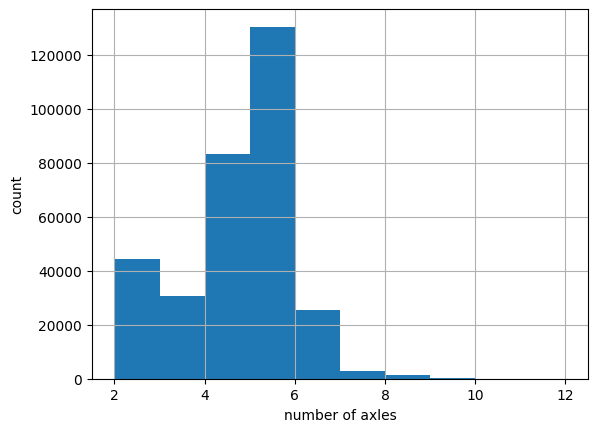

In [16]:
data['number_of_axles'].hist()
plt.xlabel('number of axles')
plt.ylabel('count')

In [17]:
axles_data = {}

for i in range(min(data['number_of_axles']), max(data['number_of_axles']) + 1):
    # Generate the list of column names dynamically
    axle_columns = [f'axle {j} [kg]' for j in range(1, i + 1)]
    
    # Check if all required columns exist in the dataset
    valid_columns = [col for col in axle_columns if col in data.columns]
    
    # Filter the data for the specific number of axles and only keep valid columns
    axles_data[i] = data[data['number_of_axles'] == i][valid_columns]



In [18]:
axles_data[9]
axles_data[7].reset_index(drop=True)

,axle 1 [kg],axle 2 [kg],axle 3 [kg],axle 4 [kg],axle 5 [kg],axle 6 [kg],axle 7 [kg]
0,4417,4965,3657.0,3975.0,8448.0,7699.0,7253.0
1,5091,5388,4222.0,4091.0,3413.0,3299.0,3170.0
2,8533,8449,7753.0,8274.0,7128.0,7284.0,7185.0
3,7388,3965,6256.0,6698.0,6866.0,6816.0,6787.0
4,7026,4641,6218.0,6222.0,4821.0,4816.0,4803.0
...,...,...,...,...,...,...,...
2720,5588,4641,4107.0,4108.0,2422.0,2475.0,2519.0
2721,6981,10992,7722.0,8001.0,4659.0,4782.0,4603.0
2722,8510,8552,3519.0,3932.0,3939.0,3924.0,3886.0
2723,7547,8323,6180.0,6107.0,5591.0,5809.0,5836.0


Text(0.5, 1.0, 'axle 4 [kg]')

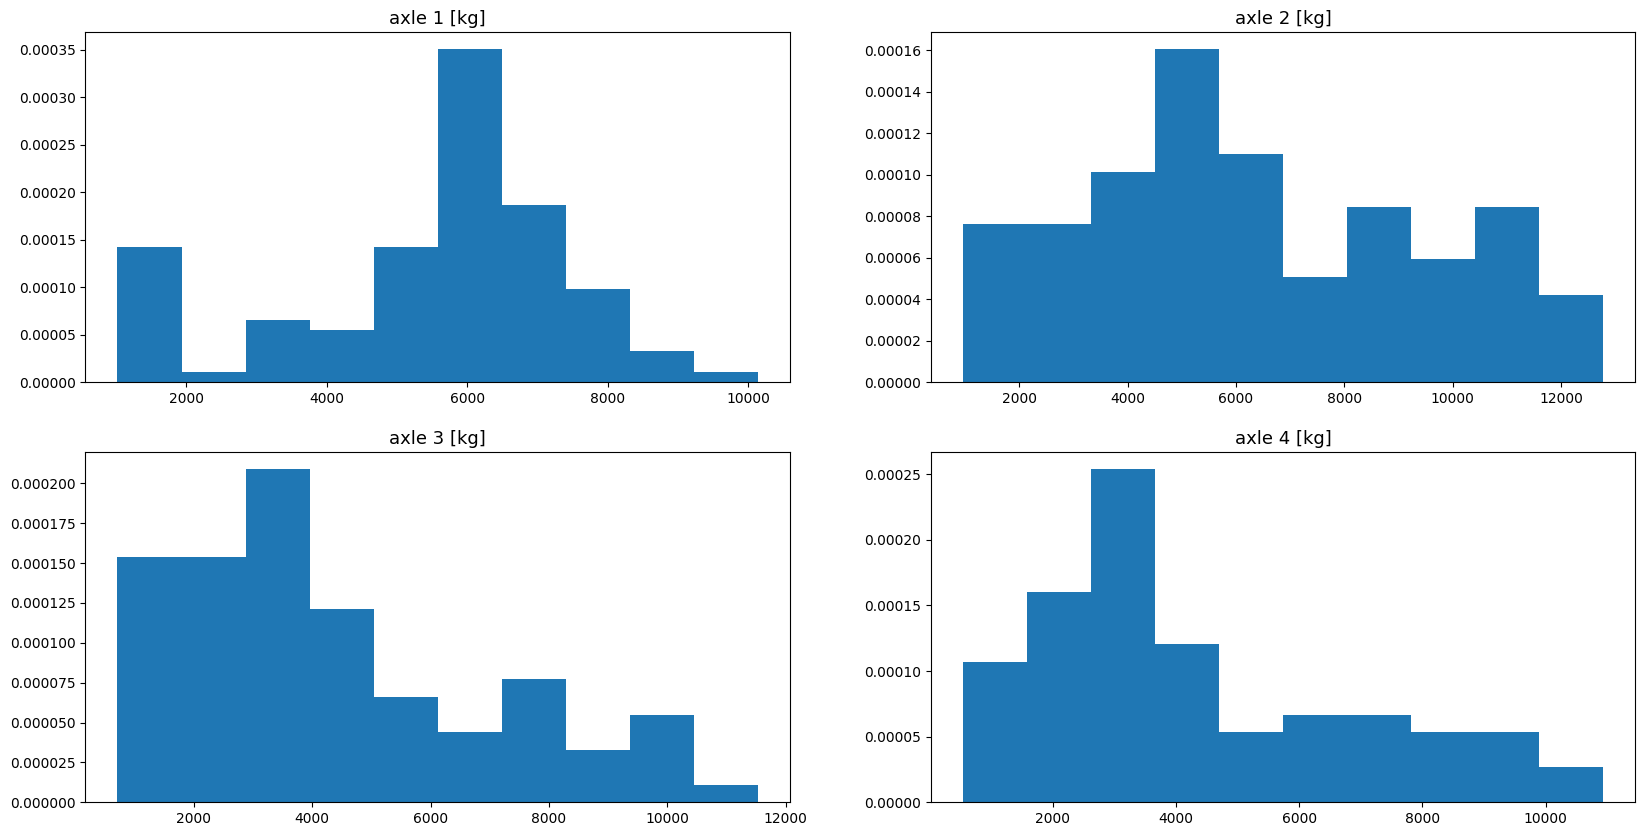

In [19]:
data.shape
fig   = plt.figure( figsize = (20,10))
gs    = gridspec.GridSpec( ncols = 2, nrows = 2, figure = fig)
ax11   = fig.add_subplot( gs[0, 0] )
ax12   = fig.add_subplot( gs[0, 1] )
ax21   = fig.add_subplot( gs[1, 0] )
ax22   = fig.add_subplot( gs[1, 1] )

ax11.hist(data['axle 1 [kg]'][:100], density=True)
ax11.set_title('axle 1 [kg]',fontsize=13)
ax12.hist(data['axle 2 [kg]'][:100], density=True)
ax12.set_title('axle 2 [kg]',fontsize=13)
ax21.hist(data['axle 3 [kg]'][:100], density=True)
ax21.set_title('axle 3 [kg]',fontsize=13)
ax22.hist(data['axle 4 [kg]'][:100], density=True)
ax22.set_title('axle 4 [kg]',fontsize=13)

In [20]:
def unity(data):
    M = data.shape[0]  # Reading number of observations per node
    ranks = data.rank(axis=0)
    u_hat = ranks / (M + 1)
    return u_hat


# Loop through each axle count in axles_data
# for axle_count, subset_data in axles_data.items():
#     # Apply the unity function
#     unity_data = unity(subset_data)

#     # Create a pair plot for the transformed data
#     sns.pairplot(unity_data, kind = 'hist', height=2)
#     plt.suptitle(f'Pair Plot for {axle_count} Axles', y=1.02)  # Add a title
#     plt.tight_layout()

#     # Save the plot to a file (optional)
#     plt.savefig(f"pairplot_axles_{axle_count}.png")
#     print(f"Saved pair plot for {axle_count} axles to 'pairplot_axles_{axle_count}.png'")

#     # Show the plot (optional)
#     plt.show()

    

In [21]:
import warnings  
warnings.filterwarnings("ignore")

data = axles_data[9].reset_index(drop=True)
#data = data.sample(n=1000, random_state=42)
#print(data)

names = ['axle 1 [kg]', 'axle 2 [kg]','axle 3 [kg]', 'axle 4 [kg]', 'axle 5 [kg]','axle 6 [kg]','axle 7 [kg]', 'axle 8 [kg]','axle 9 [kg]']
M = cvm_statistic(data, names, plot=True, fig_name='')
print(M)
    
# for axle_count, subset_data in axles_data.items():
#     if axle_count == 2:
#         continue
#     data = subset_data.reset_index(drop=True)
#     data = data.sample(n=1000, random_state=42)
    
#     names = [f'axle {axle} [kg]' for axle in range(1, axle_count+1)]
#     print(names)
    
#     M = cvm_statistic(data, names, plot=True, fig_name='')
#     print(M)
plt.show()

AttributeError: module 'numpy' has no attribute 'math'